In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os, fnmatch
import zipfile
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tf.executing_eagerly()

2022-11-19 21:48:51.502345: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


True

In [2]:
!wget --no-check-certificate \  "https://www.dropbox.com/s/0pzcixbixtskxjm/UTKFace_downsampled.zip" \
    -O "/tmp/age.zip"

--2022-11-19 21:49:00--  http://%20/
Resolving   ( )... failed: Name or service not known.
wget: unable to resolve host address ‘ ’
--2022-11-19 21:49:00--  https://www.dropbox.com/s/0pzcixbixtskxjm/UTKFace_downsampled.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/0pzcixbixtskxjm/UTKFace_downsampled.zip [following]
--2022-11-19 21:49:01--  https://www.dropbox.com/s/raw/0pzcixbixtskxjm/UTKFace_downsampled.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd0c23d74509aed2d48cea6388a.dl.dropboxusercontent.com/cd/0/inline/BxHgNDx0BOpTFsrbugItP0ayP8Chq0b31CwBEQisLP4inUF_p5ur5v_HTIJcPk_7KOdOCoE17E9loG7n7YKqexJASwDy3Klu-YaNW_qzWCnccajsUhOL6qwvNjZNRrLykrLVEQeqTfsoCt9GY1IpQHbJNGxopwgPn1odL37G8eKjVw/file# [following]
--2022-11-19

In [3]:
local_zip = '/tmp/age.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
train_data_path = "/tmp/UTKFace_downsampled/training_set/"
validation_data_path = "/tmp/UTKFace_downsampled/validation_set/"
test_data_path = "/tmp/UTKFace_downsampled/test_set/"

In [5]:
def check_file_name(data_path):

    files_to_rename = fnmatch.filter(os.listdir(data_path), '*(*)*')
    

    if len(files_to_rename) is not 0:
        print(f'the count of files to rename to be in same filename formate is {len(files_to_rename)}')
        for fl in files_to_rename:
            new_filename = fl.replace(' (1)', '')
            os.rename(data_path + fl, data_path + new_filename)
    print("The file names are in proper shape!")

<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_48654/2103537169.py:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(files_to_rename) is not 0:


In [6]:
check_file_name(train_data_path)
check_file_name(validation_data_path)

The file names are in proper shape!
The file names are in proper shape!


In [7]:
def extract_dataframe_from_dataset(data_path):

    df = pd.DataFrame(columns = ['label', 'filename'])

    for image in os.listdir(data_path):
        aux = {}
        lbl = image.split('.')[0].split('_')[0]
        aux = {'label': lbl,
           'filename': image}
        df = df.append(aux, ignore_index=True)
    df['label'] = df['label'].astype('int')

    return df

train_dataframe = extract_dataframe_from_dataset(train_data_path)
validation_dataframe = extract_dataframe_from_dataset(validation_data_path)
test_dataframe = extract_dataframe_from_dataset(test_data_path)
print(train_dataframe.shape , validation_dataframe.shape)

(5400, 2) (2315, 2)


In [8]:
# Load the first example of a horse
sample_image  = load_img(f"{os.path.join(train_data_path, os.listdir(train_data_path)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (91, 91, 3)


Sample image:


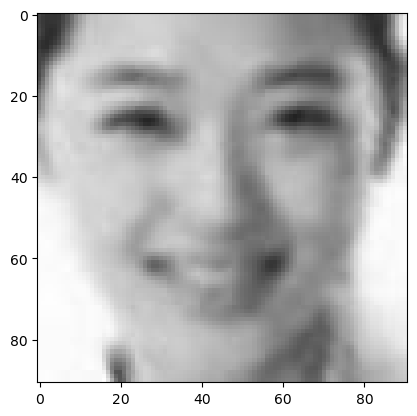

In [9]:
print("Sample image:")
plt.imshow(load_img(f"{os.path.join(train_data_path, os.listdir(train_data_path)[0])}"))
plt.show()

In [8]:
def train_val_generator(train_df, valid_df, train_dir, valid_dir, test_df, test_dir, agumentation = True):
    if agumentation is True :
        train_datagen = ImageDataGenerator(rescale= 1.0/ 255.0,
                                           rotation_range = 0.4,
                                           width_shift_range = 0.2,
                                           height_shift_range = 0.2,
                                           
                                           shear_range = 0.2,
                                           zoom_range = 0.2,
                                           horizontal_flip = True,
                                           vertical_flip = True,
                                           fill_mode = "nearest")
        
    else:
        train_datagen = ImageDataGenerator(rescale= 1.0/ 255.0)
    
    train_gen = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                 directory = train_dir,
                                                 x_col = 'filename',
                                                 y_col = 'label',
                                                 batch_size = 512,
                                                 target_size = (91, 91),
                                                 color_mode = 'grayscale',
                                                 class_mode = 'raw')
    
    validation_datagen = ImageDataGenerator(rescale= 1.0 / 255.0)

    valid_gen = validation_datagen.flow_from_dataframe(dataframe = valid_df,
                                                      directory = valid_dir,
                                                      x_col = 'filename',
                                                      y_col = 'label',
                                                      batch_size = 128,
                                                      target_size = (91, 91),
                                                      color_mode = 'grayscale',
                                                      class_mode = 'raw')
    test_datagen = ImageDataGenerator(rescale= 1.0 / 255.0)
    
    tst_gen = test_datagen.flow_from_dataframe(dataframe= test_df,
                                              directory= test_dir,
                                              x_col = 'filename',
                                              y_col = 'label',
                                              target_size = (91, 91),
                                              color_mode = 'grayscale',
                                              class_mode = 'raw')
    
    return train_gen, valid_gen, tst_gen

    
train_generator, validation_generator, test_generator = train_val_generator(train_dataframe, validation_dataframe, train_data_path, validation_data_path, test_dataframe, test_data_path)   

Found 5400 validated image filenames.
Found 2315 validated image filenames.
Found 1159 validated image filenames.


In [11]:
fle_s = 'model-sinan.{epoch:02d}-{val_mean_absolute_error:.2f}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(fle_s,monitor='val_mean_absolute_error',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',save_freq='epoch')
Early_stop = tf.keras.callbacks.EarlyStopping(patience=150,monitor='val_mean_absolute_error',restore_best_weights=True)
callback_list=[Early_stop]

In [12]:
def create_model():

    mdl = tf.keras.models.Sequential([
        # first Convolutional Layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu', input_shape = (91, 91, 1), kernel_regularizer =tf.keras.regularizers.L2(0.01)),
        #tf.keras.layers.LayerNormalization(axis=3,center=True,scale=True),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.187),

        # second Convolutional Layer
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation = 'relu',  kernel_regularizer =tf.keras.regularizers.L2(0.01)),
        #tf.keras.layers.LayerNormalization(axis=3,center=True,scale=True),
        tf.keras.layers.MaxPooling2D(2, 2),
        #tf.keras.layers.Dropout(0.187),

        # third Concolutional Layer
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", activation = 'relu', kernel_regularizer =tf.keras.regularizers.L2(0.01)),
        #tf.keras.layers.LayerNormalization(axis=3,center=True,scale=True),
        #tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.187),

        # 4'th Concolutional Layer
        tf.keras.layers.Conv2D(512, (3, 3), padding = "same", activation = 'relu', kernel_regularizer =tf.keras.regularizers.L2(0.01)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.187),

        # 5'th Concolutional Layer
        tf.keras.layers.Conv2D(1024, (3, 3), padding = "same", activation = 'relu', kernel_regularizer =tf.keras.regularizers.L2(0.01)),
        tf.keras.layers.Dropout(0.187),



        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation = 'relu', kernel_regularizer =tf.keras.regularizers.L2(0.02)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer =tf.keras.regularizers.L2(0.02)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer =tf.keras.regularizers.L2(0.02)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = 'relu')

    ])

    mdl.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss = tf.keras.losses.MeanSquaredError(),
                metrics = [tf.keras.metrics.MeanAbsoluteError()])
    return mdl

model = create_model()
model.build((None, 91, 91, 1))

2022-11-16 14:35:21.683097: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-16 14:35:21.684156: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-16 14:35:21.732357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-11-16 14:35:21.732398: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-16 14:35:21.734625: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-16 14:35:21.734703: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 91, 91, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 256)       2

In [14]:
history = model.fit(train_generator,
                    epochs=5000,
                    verbose=2,
                    validation_data=validation_generator, callbacks= callback_list)

2022-11-16 14:35:23.802180: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-16 14:35:23.822868: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


Epoch 1/5000


2022-11-16 14:35:25.097675: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-16 14:35:25.370700: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


11/11 - 16s - loss: 4138.9565 - mean_absolute_error: 40.9804 - val_loss: 1397.3602 - val_mean_absolute_error: 32.0086
Epoch 2/5000
11/11 - 8s - loss: 1396.7673 - mean_absolute_error: 32.0060 - val_loss: 1394.2241 - val_mean_absolute_error: 31.9806
Epoch 3/5000
11/11 - 7s - loss: 1389.4734 - mean_absolute_error: 31.9142 - val_loss: 1386.6125 - val_mean_absolute_error: 31.8895
Epoch 4/5000
11/11 - 7s - loss: 1159.7422 - mean_absolute_error: 28.2529 - val_loss: 920.9340 - val_mean_absolute_error: 24.9518
Epoch 5/5000
11/11 - 8s - loss: 656.8865 - mean_absolute_error: 19.6943 - val_loss: 1115.2780 - val_mean_absolute_error: 27.8893
Epoch 6/5000
11/11 - 7s - loss: 589.7831 - mean_absolute_error: 18.6521 - val_loss: 1131.4109 - val_mean_absolute_error: 28.1235
Epoch 7/5000
11/11 - 7s - loss: 544.4199 - mean_absolute_error: 17.9011 - val_loss: 1057.6429 - val_mean_absolute_error: 27.0375
Epoch 8/5000
11/11 - 8s - loss: 531.7870 - mean_absolute_error: 17.6839 - val_loss: 1025.3276 - val_mean_a

Epoch 65/5000
11/11 - 7s - loss: 288.8777 - mean_absolute_error: 12.4649 - val_loss: 469.1469 - val_mean_absolute_error: 16.6482
Epoch 66/5000
11/11 - 7s - loss: 287.5112 - mean_absolute_error: 12.5220 - val_loss: 517.7206 - val_mean_absolute_error: 17.7996
Epoch 67/5000
11/11 - 7s - loss: 285.0891 - mean_absolute_error: 12.3946 - val_loss: 724.8542 - val_mean_absolute_error: 21.9830
Epoch 68/5000
11/11 - 7s - loss: 284.4326 - mean_absolute_error: 12.3686 - val_loss: 492.3241 - val_mean_absolute_error: 17.1682
Epoch 69/5000
11/11 - 7s - loss: 281.7252 - mean_absolute_error: 12.3776 - val_loss: 557.3729 - val_mean_absolute_error: 18.5586
Epoch 70/5000
11/11 - 7s - loss: 270.0546 - mean_absolute_error: 11.9330 - val_loss: 525.9347 - val_mean_absolute_error: 17.9040
Epoch 71/5000
11/11 - 7s - loss: 267.1820 - mean_absolute_error: 11.9937 - val_loss: 700.1226 - val_mean_absolute_error: 21.5384
Epoch 72/5000
11/11 - 7s - loss: 272.5125 - mean_absolute_error: 12.0790 - val_loss: 588.6721 - v

Epoch 129/5000
11/11 - 7s - loss: 214.7334 - mean_absolute_error: 10.4149 - val_loss: 322.3251 - val_mean_absolute_error: 12.7640
Epoch 130/5000
11/11 - 7s - loss: 211.5207 - mean_absolute_error: 10.2919 - val_loss: 279.6949 - val_mean_absolute_error: 11.7302
Epoch 131/5000
11/11 - 7s - loss: 228.1247 - mean_absolute_error: 10.6646 - val_loss: 268.0782 - val_mean_absolute_error: 11.2107
Epoch 132/5000
11/11 - 7s - loss: 224.4371 - mean_absolute_error: 10.6178 - val_loss: 259.5472 - val_mean_absolute_error: 11.1782
Epoch 133/5000
11/11 - 7s - loss: 231.0176 - mean_absolute_error: 10.8477 - val_loss: 315.9056 - val_mean_absolute_error: 12.5021
Epoch 134/5000
11/11 - 7s - loss: 226.0752 - mean_absolute_error: 10.5627 - val_loss: 314.5084 - val_mean_absolute_error: 12.6484
Epoch 135/5000
11/11 - 7s - loss: 217.7016 - mean_absolute_error: 10.4691 - val_loss: 311.1869 - val_mean_absolute_error: 12.3687
Epoch 136/5000
11/11 - 7s - loss: 222.4984 - mean_absolute_error: 10.5244 - val_loss: 340.

Epoch 193/5000
11/11 - 7s - loss: 184.8354 - mean_absolute_error: 9.4193 - val_loss: 160.3899 - val_mean_absolute_error: 8.2809
Epoch 194/5000
11/11 - 7s - loss: 176.4379 - mean_absolute_error: 9.2272 - val_loss: 171.1504 - val_mean_absolute_error: 8.6412
Epoch 195/5000
11/11 - 8s - loss: 193.8167 - mean_absolute_error: 9.7871 - val_loss: 181.1141 - val_mean_absolute_error: 8.7793
Epoch 196/5000
11/11 - 7s - loss: 188.5750 - mean_absolute_error: 9.5496 - val_loss: 172.2372 - val_mean_absolute_error: 8.6301
Epoch 197/5000
11/11 - 8s - loss: 178.0212 - mean_absolute_error: 9.2940 - val_loss: 155.8633 - val_mean_absolute_error: 8.1614
Epoch 198/5000
11/11 - 7s - loss: 181.1755 - mean_absolute_error: 9.4276 - val_loss: 159.4703 - val_mean_absolute_error: 8.2304
Epoch 199/5000
11/11 - 7s - loss: 179.6703 - mean_absolute_error: 9.2651 - val_loss: 181.3026 - val_mean_absolute_error: 8.7556
Epoch 200/5000
11/11 - 7s - loss: 186.7190 - mean_absolute_error: 9.5021 - val_loss: 151.6599 - val_mean

Epoch 257/5000
11/11 - 7s - loss: 158.3689 - mean_absolute_error: 8.6763 - val_loss: 133.6998 - val_mean_absolute_error: 7.4526
Epoch 258/5000
11/11 - 7s - loss: 154.6236 - mean_absolute_error: 8.5344 - val_loss: 132.9726 - val_mean_absolute_error: 7.3707
Epoch 259/5000
11/11 - 7s - loss: 159.5958 - mean_absolute_error: 8.6955 - val_loss: 145.1721 - val_mean_absolute_error: 7.7645
Epoch 260/5000
11/11 - 7s - loss: 158.1141 - mean_absolute_error: 8.6523 - val_loss: 147.6383 - val_mean_absolute_error: 7.9247
Epoch 261/5000
11/11 - 7s - loss: 157.0735 - mean_absolute_error: 8.5753 - val_loss: 132.7395 - val_mean_absolute_error: 7.4581
Epoch 262/5000
11/11 - 10s - loss: 150.6186 - mean_absolute_error: 8.4027 - val_loss: 136.4037 - val_mean_absolute_error: 7.5251
Epoch 263/5000
11/11 - 7s - loss: 157.5601 - mean_absolute_error: 8.5696 - val_loss: 124.7667 - val_mean_absolute_error: 7.3588
Epoch 264/5000
11/11 - 8s - loss: 155.7231 - mean_absolute_error: 8.5643 - val_loss: 125.9395 - val_mea

Epoch 321/5000
11/11 - 7s - loss: 136.5308 - mean_absolute_error: 7.9254 - val_loss: 120.1765 - val_mean_absolute_error: 6.9174
Epoch 322/5000
11/11 - 7s - loss: 140.2439 - mean_absolute_error: 8.0547 - val_loss: 113.3877 - val_mean_absolute_error: 6.8768
Epoch 323/5000
11/11 - 10s - loss: 141.2379 - mean_absolute_error: 8.1318 - val_loss: 114.4398 - val_mean_absolute_error: 6.7974
Epoch 324/5000
11/11 - 7s - loss: 138.3020 - mean_absolute_error: 8.0292 - val_loss: 116.3981 - val_mean_absolute_error: 6.7871
Epoch 325/5000
11/11 - 7s - loss: 136.0534 - mean_absolute_error: 7.8814 - val_loss: 114.9799 - val_mean_absolute_error: 6.7672
Epoch 326/5000
11/11 - 7s - loss: 134.5269 - mean_absolute_error: 7.7834 - val_loss: 117.5929 - val_mean_absolute_error: 6.9562
Epoch 327/5000
11/11 - 7s - loss: 137.4672 - mean_absolute_error: 7.9328 - val_loss: 111.8070 - val_mean_absolute_error: 6.7065
Epoch 328/5000
11/11 - 7s - loss: 130.2832 - mean_absolute_error: 7.6304 - val_loss: 112.1157 - val_mea

Epoch 385/5000
11/11 - 7s - loss: 126.1778 - mean_absolute_error: 7.5397 - val_loss: 105.8150 - val_mean_absolute_error: 6.4580
Epoch 386/5000
11/11 - 7s - loss: 133.1913 - mean_absolute_error: 7.8429 - val_loss: 108.6766 - val_mean_absolute_error: 6.5994
Epoch 387/5000
11/11 - 7s - loss: 121.6914 - mean_absolute_error: 7.4482 - val_loss: 105.8376 - val_mean_absolute_error: 6.6499
Epoch 388/5000
11/11 - 7s - loss: 119.5321 - mean_absolute_error: 7.3250 - val_loss: 104.1133 - val_mean_absolute_error: 6.4555
Epoch 389/5000
11/11 - 7s - loss: 120.5730 - mean_absolute_error: 7.3980 - val_loss: 106.6024 - val_mean_absolute_error: 6.4291
Epoch 390/5000
11/11 - 8s - loss: 120.5851 - mean_absolute_error: 7.3319 - val_loss: 105.1607 - val_mean_absolute_error: 6.4914
Epoch 391/5000
11/11 - 7s - loss: 118.1627 - mean_absolute_error: 7.2668 - val_loss: 103.3336 - val_mean_absolute_error: 6.4739
Epoch 392/5000
11/11 - 7s - loss: 126.1127 - mean_absolute_error: 7.4920 - val_loss: 112.9238 - val_mean

11/11 - 7s - loss: 107.7241 - mean_absolute_error: 6.8862 - val_loss: 99.2747 - val_mean_absolute_error: 6.2754
Epoch 450/5000
11/11 - 7s - loss: 108.9152 - mean_absolute_error: 6.8889 - val_loss: 108.6481 - val_mean_absolute_error: 6.6833
Epoch 451/5000
11/11 - 7s - loss: 110.2605 - mean_absolute_error: 6.9522 - val_loss: 97.8262 - val_mean_absolute_error: 6.1482
Epoch 452/5000
11/11 - 9s - loss: 106.2344 - mean_absolute_error: 6.7505 - val_loss: 98.9673 - val_mean_absolute_error: 6.1643
Epoch 453/5000
11/11 - 8s - loss: 114.5038 - mean_absolute_error: 7.0928 - val_loss: 99.3685 - val_mean_absolute_error: 6.3328
Epoch 454/5000
11/11 - 7s - loss: 109.4550 - mean_absolute_error: 6.9577 - val_loss: 100.2003 - val_mean_absolute_error: 6.2619
Epoch 455/5000
11/11 - 7s - loss: 108.3427 - mean_absolute_error: 6.8948 - val_loss: 99.9674 - val_mean_absolute_error: 6.2475
Epoch 456/5000
11/11 - 7s - loss: 108.8106 - mean_absolute_error: 6.8960 - val_loss: 98.6311 - val_mean_absolute_error: 6.20

Epoch 514/5000
11/11 - 7s - loss: 98.6542 - mean_absolute_error: 6.5521 - val_loss: 98.5219 - val_mean_absolute_error: 6.1756
Epoch 515/5000
11/11 - 7s - loss: 101.5140 - mean_absolute_error: 6.6285 - val_loss: 98.2640 - val_mean_absolute_error: 6.1802
Epoch 516/5000
11/11 - 7s - loss: 102.9863 - mean_absolute_error: 6.6822 - val_loss: 99.1864 - val_mean_absolute_error: 6.1488
Epoch 517/5000
11/11 - 7s - loss: 99.2866 - mean_absolute_error: 6.5533 - val_loss: 95.6752 - val_mean_absolute_error: 6.0485
Epoch 518/5000
11/11 - 7s - loss: 97.7093 - mean_absolute_error: 6.4793 - val_loss: 106.5521 - val_mean_absolute_error: 6.5694
Epoch 519/5000
11/11 - 7s - loss: 101.9352 - mean_absolute_error: 6.6632 - val_loss: 103.7281 - val_mean_absolute_error: 6.4463
Epoch 520/5000
11/11 - 7s - loss: 97.0290 - mean_absolute_error: 6.5111 - val_loss: 96.9648 - val_mean_absolute_error: 6.1854
Epoch 521/5000
11/11 - 7s - loss: 95.3260 - mean_absolute_error: 6.3668 - val_loss: 97.9969 - val_mean_absolute_e

Epoch 579/5000
11/11 - 7s - loss: 94.6743 - mean_absolute_error: 6.3593 - val_loss: 96.1432 - val_mean_absolute_error: 6.0051
Epoch 580/5000
11/11 - 7s - loss: 90.7446 - mean_absolute_error: 6.2106 - val_loss: 95.1709 - val_mean_absolute_error: 6.0551
Epoch 581/5000
11/11 - 7s - loss: 90.9911 - mean_absolute_error: 6.1979 - val_loss: 93.9223 - val_mean_absolute_error: 5.9454
Epoch 582/5000
11/11 - 7s - loss: 93.0165 - mean_absolute_error: 6.2846 - val_loss: 102.1312 - val_mean_absolute_error: 6.3282
Epoch 583/5000
11/11 - 7s - loss: 95.3670 - mean_absolute_error: 6.4340 - val_loss: 98.1813 - val_mean_absolute_error: 6.1909
Epoch 584/5000
11/11 - 7s - loss: 91.6566 - mean_absolute_error: 6.2410 - val_loss: 95.4535 - val_mean_absolute_error: 5.9938
Epoch 585/5000
11/11 - 7s - loss: 92.5784 - mean_absolute_error: 6.2377 - val_loss: 91.8108 - val_mean_absolute_error: 6.0082
Epoch 586/5000
11/11 - 7s - loss: 90.4183 - mean_absolute_error: 6.2042 - val_loss: 94.4487 - val_mean_absolute_error

Epoch 644/5000
11/11 - 7s - loss: 88.7457 - mean_absolute_error: 6.1723 - val_loss: 94.1395 - val_mean_absolute_error: 5.9239
Epoch 645/5000
11/11 - 7s - loss: 85.8651 - mean_absolute_error: 6.0136 - val_loss: 94.1491 - val_mean_absolute_error: 5.9608
Epoch 646/5000
11/11 - 7s - loss: 88.1260 - mean_absolute_error: 6.1550 - val_loss: 91.4747 - val_mean_absolute_error: 5.8704
Epoch 647/5000
11/11 - 7s - loss: 88.6341 - mean_absolute_error: 6.1227 - val_loss: 91.2963 - val_mean_absolute_error: 5.8837
Epoch 648/5000
11/11 - 7s - loss: 88.9222 - mean_absolute_error: 6.1151 - val_loss: 97.9251 - val_mean_absolute_error: 6.0378
Epoch 649/5000
11/11 - 7s - loss: 86.2948 - mean_absolute_error: 6.0373 - val_loss: 95.9659 - val_mean_absolute_error: 5.9892
Epoch 650/5000
11/11 - 9s - loss: 88.9356 - mean_absolute_error: 6.1197 - val_loss: 91.7577 - val_mean_absolute_error: 5.8776
Epoch 651/5000
11/11 - 7s - loss: 87.2205 - mean_absolute_error: 6.0387 - val_loss: 91.3914 - val_mean_absolute_error:

Epoch 709/5000
11/11 - 7s - loss: 80.1873 - mean_absolute_error: 5.7773 - val_loss: 92.1596 - val_mean_absolute_error: 5.9016
Epoch 710/5000
11/11 - 7s - loss: 83.3703 - mean_absolute_error: 5.8631 - val_loss: 92.3933 - val_mean_absolute_error: 5.8929
Epoch 711/5000
11/11 - 7s - loss: 83.5773 - mean_absolute_error: 5.9152 - val_loss: 89.4416 - val_mean_absolute_error: 5.8251
Epoch 712/5000
11/11 - 10s - loss: 81.9002 - mean_absolute_error: 5.7959 - val_loss: 94.4701 - val_mean_absolute_error: 6.0849
Epoch 713/5000
11/11 - 7s - loss: 80.8625 - mean_absolute_error: 5.7773 - val_loss: 90.1328 - val_mean_absolute_error: 5.8647
Epoch 714/5000
11/11 - 7s - loss: 78.6323 - mean_absolute_error: 5.7480 - val_loss: 90.6208 - val_mean_absolute_error: 5.9119
Epoch 715/5000
11/11 - 7s - loss: 85.2927 - mean_absolute_error: 5.9877 - val_loss: 91.4064 - val_mean_absolute_error: 6.0167
Epoch 716/5000
11/11 - 7s - loss: 80.8517 - mean_absolute_error: 5.8113 - val_loss: 90.2589 - val_mean_absolute_error

Epoch 774/5000
11/11 - 10s - loss: 75.7641 - mean_absolute_error: 5.5222 - val_loss: 90.7517 - val_mean_absolute_error: 5.8587
Epoch 775/5000
11/11 - 7s - loss: 76.6495 - mean_absolute_error: 5.6285 - val_loss: 93.3537 - val_mean_absolute_error: 5.8614
Epoch 776/5000
11/11 - 7s - loss: 79.3028 - mean_absolute_error: 5.7094 - val_loss: 91.8170 - val_mean_absolute_error: 5.8833
Epoch 777/5000
11/11 - 7s - loss: 80.4831 - mean_absolute_error: 5.7524 - val_loss: 89.9443 - val_mean_absolute_error: 5.8128
Epoch 778/5000
11/11 - 7s - loss: 78.8893 - mean_absolute_error: 5.6667 - val_loss: 90.4319 - val_mean_absolute_error: 5.8634
Epoch 779/5000
11/11 - 7s - loss: 79.1917 - mean_absolute_error: 5.6702 - val_loss: 92.4997 - val_mean_absolute_error: 5.9617
Epoch 780/5000
11/11 - 7s - loss: 81.9059 - mean_absolute_error: 5.8300 - val_loss: 94.9573 - val_mean_absolute_error: 5.9718
Epoch 781/5000
11/11 - 7s - loss: 79.5767 - mean_absolute_error: 5.7036 - val_loss: 92.5743 - val_mean_absolute_error

11/11 - 7s - loss: 71.6390 - mean_absolute_error: 5.3765 - val_loss: 88.2303 - val_mean_absolute_error: 5.8242
Epoch 840/5000
11/11 - 7s - loss: 75.9093 - mean_absolute_error: 5.5541 - val_loss: 88.7577 - val_mean_absolute_error: 5.7923
Epoch 841/5000
11/11 - 7s - loss: 77.7738 - mean_absolute_error: 5.6325 - val_loss: 89.6151 - val_mean_absolute_error: 5.8429
Epoch 842/5000
11/11 - 7s - loss: 76.5829 - mean_absolute_error: 5.5373 - val_loss: 88.9656 - val_mean_absolute_error: 5.7996
Epoch 843/5000
11/11 - 7s - loss: 75.4763 - mean_absolute_error: 5.5473 - val_loss: 90.4998 - val_mean_absolute_error: 5.8785
Epoch 844/5000
11/11 - 7s - loss: 77.5246 - mean_absolute_error: 5.6217 - val_loss: 91.1737 - val_mean_absolute_error: 5.8181
Epoch 845/5000
11/11 - 7s - loss: 74.5990 - mean_absolute_error: 5.4884 - val_loss: 93.1466 - val_mean_absolute_error: 5.8704
Epoch 846/5000
11/11 - 7s - loss: 76.0961 - mean_absolute_error: 5.5907 - val_loss: 94.5057 - val_mean_absolute_error: 5.9305
Epoch 8

Epoch 905/5000
11/11 - 7s - loss: 71.8756 - mean_absolute_error: 5.3365 - val_loss: 89.6406 - val_mean_absolute_error: 5.7455
Epoch 906/5000
11/11 - 7s - loss: 71.9878 - mean_absolute_error: 5.3742 - val_loss: 87.2828 - val_mean_absolute_error: 5.7089
Epoch 907/5000
11/11 - 7s - loss: 70.2275 - mean_absolute_error: 5.2823 - val_loss: 89.8820 - val_mean_absolute_error: 5.7289
Epoch 908/5000
11/11 - 7s - loss: 70.0688 - mean_absolute_error: 5.2883 - val_loss: 93.3684 - val_mean_absolute_error: 5.8515
Epoch 909/5000
11/11 - 7s - loss: 71.2090 - mean_absolute_error: 5.3522 - val_loss: 90.8861 - val_mean_absolute_error: 5.8577
Epoch 910/5000
11/11 - 8s - loss: 72.6779 - mean_absolute_error: 5.4321 - val_loss: 89.2318 - val_mean_absolute_error: 5.8302
Epoch 911/5000
11/11 - 7s - loss: 72.5911 - mean_absolute_error: 5.3668 - val_loss: 89.0750 - val_mean_absolute_error: 5.7453
Epoch 912/5000
11/11 - 7s - loss: 71.0530 - mean_absolute_error: 5.2596 - val_loss: 91.8590 - val_mean_absolute_error:

11/11 - 7s - loss: 73.3526 - mean_absolute_error: 5.4524 - val_loss: 90.0216 - val_mean_absolute_error: 5.7919
Epoch 971/5000
11/11 - 7s - loss: 72.7852 - mean_absolute_error: 5.3785 - val_loss: 87.9723 - val_mean_absolute_error: 5.6891
Epoch 972/5000
11/11 - 7s - loss: 71.0077 - mean_absolute_error: 5.2983 - val_loss: 86.8059 - val_mean_absolute_error: 5.7021
Epoch 973/5000
11/11 - 7s - loss: 69.1737 - mean_absolute_error: 5.2045 - val_loss: 87.4351 - val_mean_absolute_error: 5.7180
Epoch 974/5000
11/11 - 7s - loss: 71.7506 - mean_absolute_error: 5.3052 - val_loss: 88.8456 - val_mean_absolute_error: 5.7127
Epoch 975/5000
11/11 - 7s - loss: 71.1063 - mean_absolute_error: 5.2881 - val_loss: 86.9314 - val_mean_absolute_error: 5.7964
Epoch 976/5000
11/11 - 7s - loss: 69.1766 - mean_absolute_error: 5.2241 - val_loss: 97.0984 - val_mean_absolute_error: 6.2955
Epoch 977/5000
11/11 - 7s - loss: 72.3745 - mean_absolute_error: 5.4061 - val_loss: 90.3986 - val_mean_absolute_error: 5.9322
Epoch 9

Epoch 1035/5000
11/11 - 7s - loss: 66.9926 - mean_absolute_error: 5.1026 - val_loss: 85.8490 - val_mean_absolute_error: 5.6440
Epoch 1036/5000
11/11 - 7s - loss: 67.7746 - mean_absolute_error: 5.1799 - val_loss: 88.0232 - val_mean_absolute_error: 5.6789
Epoch 1037/5000
11/11 - 7s - loss: 69.7877 - mean_absolute_error: 5.2720 - val_loss: 88.4174 - val_mean_absolute_error: 5.7259
Epoch 1038/5000
11/11 - 7s - loss: 66.5750 - mean_absolute_error: 5.1087 - val_loss: 86.0720 - val_mean_absolute_error: 5.6647
Epoch 1039/5000
11/11 - 7s - loss: 69.0862 - mean_absolute_error: 5.2158 - val_loss: 86.9511 - val_mean_absolute_error: 5.6415
Epoch 1040/5000
11/11 - 7s - loss: 68.9192 - mean_absolute_error: 5.2264 - val_loss: 87.6366 - val_mean_absolute_error: 5.6837
Epoch 1041/5000
11/11 - 7s - loss: 67.8690 - mean_absolute_error: 5.1676 - val_loss: 87.4258 - val_mean_absolute_error: 5.7193
Epoch 1042/5000
11/11 - 7s - loss: 66.6317 - mean_absolute_error: 5.0835 - val_loss: 87.3759 - val_mean_absolut

Epoch 1100/5000
11/11 - 7s - loss: 66.1853 - mean_absolute_error: 5.0692 - val_loss: 86.6740 - val_mean_absolute_error: 5.6938
Epoch 1101/5000
11/11 - 7s - loss: 64.8697 - mean_absolute_error: 4.9989 - val_loss: 85.3814 - val_mean_absolute_error: 5.6452
Epoch 1102/5000
11/11 - 7s - loss: 69.6622 - mean_absolute_error: 5.2392 - val_loss: 84.4485 - val_mean_absolute_error: 5.6412
Epoch 1103/5000
11/11 - 7s - loss: 70.7308 - mean_absolute_error: 5.2700 - val_loss: 85.4959 - val_mean_absolute_error: 5.5775
Epoch 1104/5000
11/11 - 7s - loss: 66.8056 - mean_absolute_error: 5.0924 - val_loss: 86.6918 - val_mean_absolute_error: 5.6437
Epoch 1105/5000
11/11 - 7s - loss: 66.9459 - mean_absolute_error: 5.1414 - val_loss: 86.2374 - val_mean_absolute_error: 5.6262
Epoch 1106/5000
11/11 - 8s - loss: 68.5034 - mean_absolute_error: 5.1832 - val_loss: 86.7646 - val_mean_absolute_error: 5.5969
Epoch 1107/5000
11/11 - 7s - loss: 64.5787 - mean_absolute_error: 4.9828 - val_loss: 89.5203 - val_mean_absolut

Epoch 1165/5000
11/11 - 7s - loss: 70.0757 - mean_absolute_error: 5.2775 - val_loss: 85.4848 - val_mean_absolute_error: 5.5671
Epoch 1166/5000
11/11 - 10s - loss: 67.0715 - mean_absolute_error: 5.1024 - val_loss: 85.8465 - val_mean_absolute_error: 5.6201
Epoch 1167/5000
11/11 - 7s - loss: 65.2959 - mean_absolute_error: 5.0170 - val_loss: 85.5353 - val_mean_absolute_error: 5.5977
Epoch 1168/5000
11/11 - 8s - loss: 65.7106 - mean_absolute_error: 5.0094 - val_loss: 83.5818 - val_mean_absolute_error: 5.5538
Epoch 1169/5000
11/11 - 7s - loss: 65.4035 - mean_absolute_error: 5.0393 - val_loss: 88.4847 - val_mean_absolute_error: 5.8463
Epoch 1170/5000
11/11 - 7s - loss: 68.2433 - mean_absolute_error: 5.1623 - val_loss: 83.6889 - val_mean_absolute_error: 5.6083
Epoch 1171/5000
11/11 - 7s - loss: 65.9373 - mean_absolute_error: 5.0723 - val_loss: 93.5931 - val_mean_absolute_error: 6.1000
Epoch 1172/5000
11/11 - 7s - loss: 69.2764 - mean_absolute_error: 5.2109 - val_loss: 86.2978 - val_mean_absolu

Epoch 1230/5000
11/11 - 7s - loss: 62.4948 - mean_absolute_error: 4.9221 - val_loss: 87.0612 - val_mean_absolute_error: 5.6924
Epoch 1231/5000
11/11 - 7s - loss: 63.7552 - mean_absolute_error: 4.8959 - val_loss: 85.8770 - val_mean_absolute_error: 5.6279
Epoch 1232/5000
11/11 - 7s - loss: 65.9507 - mean_absolute_error: 5.0255 - val_loss: 91.0797 - val_mean_absolute_error: 5.8800
Epoch 1233/5000
11/11 - 7s - loss: 64.8391 - mean_absolute_error: 4.9965 - val_loss: 89.0032 - val_mean_absolute_error: 5.7623
Epoch 1234/5000
11/11 - 9s - loss: 66.2125 - mean_absolute_error: 5.0867 - val_loss: 84.6405 - val_mean_absolute_error: 5.6262
Epoch 1235/5000
11/11 - 7s - loss: 63.1311 - mean_absolute_error: 4.8988 - val_loss: 91.3519 - val_mean_absolute_error: 5.7961
Epoch 1236/5000
11/11 - 7s - loss: 64.5664 - mean_absolute_error: 4.9613 - val_loss: 87.4061 - val_mean_absolute_error: 5.6735
Epoch 1237/5000
11/11 - 7s - loss: 64.4665 - mean_absolute_error: 4.9528 - val_loss: 93.0767 - val_mean_absolut

Epoch 1295/5000
11/11 - 7s - loss: 63.9020 - mean_absolute_error: 4.9809 - val_loss: 85.7101 - val_mean_absolute_error: 5.6055
Epoch 1296/5000
11/11 - 7s - loss: 65.8830 - mean_absolute_error: 5.0258 - val_loss: 87.1897 - val_mean_absolute_error: 5.6426
Epoch 1297/5000
11/11 - 7s - loss: 61.1764 - mean_absolute_error: 4.7899 - val_loss: 86.0396 - val_mean_absolute_error: 5.6242
Epoch 1298/5000
11/11 - 7s - loss: 63.7076 - mean_absolute_error: 4.9584 - val_loss: 86.1456 - val_mean_absolute_error: 5.7021
Epoch 1299/5000
11/11 - 7s - loss: 61.5023 - mean_absolute_error: 4.8147 - val_loss: 87.2327 - val_mean_absolute_error: 5.6363
Epoch 1300/5000
11/11 - 7s - loss: 63.9232 - mean_absolute_error: 4.8938 - val_loss: 89.4906 - val_mean_absolute_error: 5.7061
Epoch 1301/5000
11/11 - 7s - loss: 64.8011 - mean_absolute_error: 4.9838 - val_loss: 84.1968 - val_mean_absolute_error: 5.6125
Epoch 1302/5000
11/11 - 7s - loss: 61.6559 - mean_absolute_error: 4.8443 - val_loss: 88.1567 - val_mean_absolut

Epoch 1360/5000
11/11 - 7s - loss: 62.2808 - mean_absolute_error: 4.8969 - val_loss: 84.9756 - val_mean_absolute_error: 5.6821
Epoch 1361/5000
11/11 - 7s - loss: 62.7811 - mean_absolute_error: 4.8785 - val_loss: 85.8136 - val_mean_absolute_error: 5.7268
Epoch 1362/5000
11/11 - 7s - loss: 60.5256 - mean_absolute_error: 4.7747 - val_loss: 90.7141 - val_mean_absolute_error: 5.8706
Epoch 1363/5000
11/11 - 7s - loss: 61.3837 - mean_absolute_error: 4.7920 - val_loss: 85.8307 - val_mean_absolute_error: 5.5940
Epoch 1364/5000
11/11 - 7s - loss: 62.4411 - mean_absolute_error: 4.8812 - val_loss: 95.0395 - val_mean_absolute_error: 5.9095
Epoch 1365/5000
11/11 - 7s - loss: 63.6763 - mean_absolute_error: 4.9252 - val_loss: 92.4806 - val_mean_absolute_error: 5.8083
Epoch 1366/5000
11/11 - 7s - loss: 62.8667 - mean_absolute_error: 4.8552 - val_loss: 99.8827 - val_mean_absolute_error: 6.2273
Epoch 1367/5000
11/11 - 7s - loss: 61.1052 - mean_absolute_error: 4.8083 - val_loss: 85.9478 - val_mean_absolut

Epoch 1425/5000
11/11 - 9s - loss: 62.1898 - mean_absolute_error: 4.8396 - val_loss: 84.9801 - val_mean_absolute_error: 5.6378
Epoch 1426/5000
11/11 - 7s - loss: 61.1823 - mean_absolute_error: 4.7984 - val_loss: 86.1730 - val_mean_absolute_error: 5.6381
Epoch 1427/5000
11/11 - 7s - loss: 62.1246 - mean_absolute_error: 4.8525 - val_loss: 85.5841 - val_mean_absolute_error: 5.5786
Epoch 1428/5000
11/11 - 7s - loss: 60.5698 - mean_absolute_error: 4.7419 - val_loss: 84.6096 - val_mean_absolute_error: 5.5722
Epoch 1429/5000
11/11 - 9s - loss: 58.9450 - mean_absolute_error: 4.6795 - val_loss: 84.9016 - val_mean_absolute_error: 5.5794
Epoch 1430/5000
11/11 - 7s - loss: 59.9870 - mean_absolute_error: 4.7457 - val_loss: 86.0658 - val_mean_absolute_error: 5.6357
Epoch 1431/5000
11/11 - 7s - loss: 59.9891 - mean_absolute_error: 4.7610 - val_loss: 91.1708 - val_mean_absolute_error: 5.8300
Epoch 1432/5000
11/11 - 7s - loss: 60.5620 - mean_absolute_error: 4.7328 - val_loss: 86.6719 - val_mean_absolut

Epoch 1490/5000
11/11 - 7s - loss: 60.7025 - mean_absolute_error: 4.7221 - val_loss: 88.8694 - val_mean_absolute_error: 5.7895
Epoch 1491/5000
11/11 - 7s - loss: 62.0428 - mean_absolute_error: 4.8360 - val_loss: 86.2371 - val_mean_absolute_error: 5.5931
Epoch 1492/5000
11/11 - 7s - loss: 61.8464 - mean_absolute_error: 4.8125 - val_loss: 88.0483 - val_mean_absolute_error: 5.6836
Epoch 1493/5000
11/11 - 7s - loss: 58.9767 - mean_absolute_error: 4.6859 - val_loss: 85.2428 - val_mean_absolute_error: 5.6233
Epoch 1494/5000
11/11 - 7s - loss: 60.6181 - mean_absolute_error: 4.7856 - val_loss: 88.2451 - val_mean_absolute_error: 5.6944
Epoch 1495/5000
11/11 - 7s - loss: 59.0776 - mean_absolute_error: 4.6724 - val_loss: 87.2537 - val_mean_absolute_error: 5.6357
Epoch 1496/5000
11/11 - 7s - loss: 61.8288 - mean_absolute_error: 4.8743 - val_loss: 90.8983 - val_mean_absolute_error: 5.9184
Epoch 1497/5000
11/11 - 7s - loss: 61.0793 - mean_absolute_error: 4.8042 - val_loss: 88.0582 - val_mean_absolut

Epoch 1555/5000
11/11 - 7s - loss: 58.3596 - mean_absolute_error: 4.6139 - val_loss: 92.3720 - val_mean_absolute_error: 5.7819
Epoch 1556/5000
11/11 - 7s - loss: 60.1805 - mean_absolute_error: 4.6760 - val_loss: 83.6510 - val_mean_absolute_error: 5.5044
Epoch 1557/5000
11/11 - 7s - loss: 57.4488 - mean_absolute_error: 4.5943 - val_loss: 83.7284 - val_mean_absolute_error: 5.5912
Epoch 1558/5000
11/11 - 7s - loss: 56.0027 - mean_absolute_error: 4.5245 - val_loss: 86.1197 - val_mean_absolute_error: 5.6078
Epoch 1559/5000
11/11 - 7s - loss: 58.7095 - mean_absolute_error: 4.6066 - val_loss: 85.5445 - val_mean_absolute_error: 5.5966
Epoch 1560/5000
11/11 - 7s - loss: 58.3546 - mean_absolute_error: 4.5947 - val_loss: 87.5869 - val_mean_absolute_error: 5.6434
Epoch 1561/5000
11/11 - 7s - loss: 59.7329 - mean_absolute_error: 4.7176 - val_loss: 88.0725 - val_mean_absolute_error: 5.7268
Epoch 1562/5000
11/11 - 7s - loss: 57.6426 - mean_absolute_error: 4.6048 - val_loss: 87.2474 - val_mean_absolut

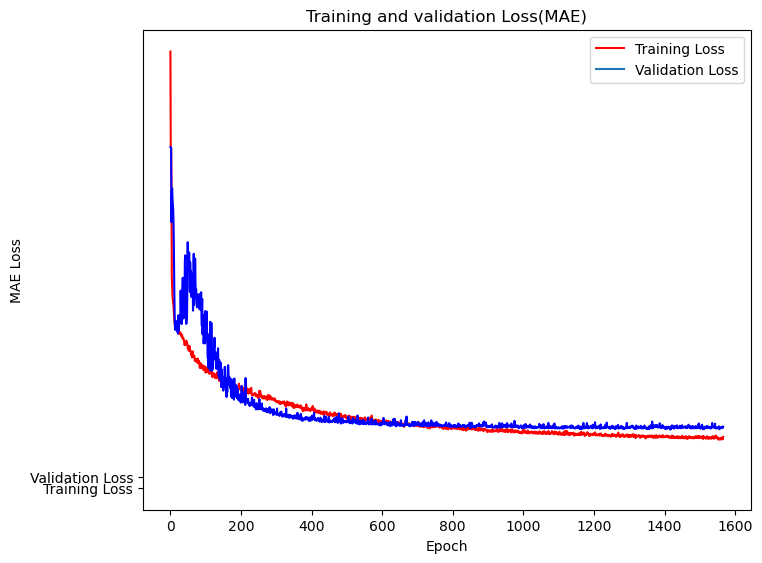

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------

loss=history.history['mean_absolute_error']
val_loss=history.history['val_mean_absolute_error']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title('Training and validation Loss(MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend(['Training Loss','Validation Loss'],loc='upper right')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0,hspace=0.25,wspace=0.35)
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch

In [16]:
y_true = []
y_pred = []
index  = 0
while index <= validation_generator.batch_index:
    aux = validation_generator.next()
    y_pred.append(np.transpose(np.rint(model.predict(aux[0]))).tolist()[0])
    y_true.append(aux[1].tolist())
    index +=1
print("the true labels are:", len(y_true))
print("the Pred size is :", len(y_pred))

y_pred = [x for l in y_pred for x in l]
y_true = [x for l in y_true for x in l]
print(len(y_pred))
print(len(y_true))

mae = tf.keras.losses.MeanAbsoluteError()
mae(y_true, y_pred).numpy()

the true labels are: 19
the Pred size is : 19
2315
2315


5.473002

In [15]:
y_true_test = []
y_pred_test = []
index  = 0
while index <= test_generator.batch_index:
    aux = test_generator.next()
    print (aux[1].shape)
    y_pred_test.append(np.transpose(np.rint(model.predict(aux[0]))).tolist()[0])
    y_true_test.append(aux[1].tolist())
    index +=1
print("the true labels are:", len(y_true_test))
print("the Pred size is :", len(y_pred_test))

y_pred_test = [x for l in y_pred_test for x in l]
y_true_test = [x for l in y_true_test for x in l]
print(len(y_pred_test))
print(len(y_true_test))

mae_test = tf.keras.losses.MeanAbsoluteError()
mae_test(y_true_test, y_pred_test).numpy()

(32,)


NameError: name 'model' is not defined

In [19]:
model.save("OR_v2_val547_tst555")

INFO:tensorflow:Assets written to: OR_v2_val547_tst555/assets


In [10]:
reconstructed_model = tf.keras.models.load_model("/home/tubitak/Desktop/OR_v2_val547_tst555")

2022-11-19 21:49:55.313008: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-19 21:49:55.314307: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-19 21:49:55.370185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-11-19 21:49:55.370225: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-19 21:49:55.372253: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-19 21:49:55.372320: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-

In [11]:
y_true_test = []
y_pred_test = []
y_filenames = []
index  = 0
while index <= test_generator.batch_index:
    aux = test_generator.next()
    y_pred_test.append(np.transpose(np.rint(reconstructed_model.predict(aux[0]))).tolist()[0])
    y_true_test.append(aux[1].tolist())
    index +=1
print("the true labels are:", len(y_true_test))
print("the Pred size is :", len(y_pred_test))

y_pred_test = [x for l in y_pred_test for x in l]
y_true_test = [x for l in y_true_test for x in l]
print(len(y_pred_test))
print(len(y_true_test))

mae_test = tf.keras.losses.MeanAbsoluteError()
mae_test(y_true_test, y_pred_test).numpy()

2022-11-19 21:51:03.652274: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-19 21:51:03.670750: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2022-11-19 21:51:03.776167: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-19 21:51:04.054272: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


the true labels are: 37
the Pred size is : 37
1159
1159


5.5513372

In [22]:
from ipywidgets import FileUpload
upload = FileUpload()

In [21]:

for fn in upload.keys():
 
  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(91, 91))
  
  x=img_to_array(img)
  x /= 255.0
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = reconstructed_model.predict(images, batch_size=10)
  
  print(classes[0])

TypeError: 'list' object is not callable